In [1]:
import numpy as np
from qiskit import *
from qiskit.circuit import Qubit
from qiskit.quantum_info import Statevector

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

Based on the adaptation of Möttönen et al's paper "Transformation of quantum states using uniformly controlled rotations".

This algorithm adaptation is written in "Supervised Learning with Quantum Computers" book by Maria Schuld and Francesco Petruccione

In [27]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 8s 1us/step


In [42]:
x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/255.0
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/255.0

In [43]:
x_train_flatten.shape, y_train.shape

((60000, 784), (60000,))

In [44]:
x_test_flatten.shape, y_test.shape

((10000, 784), (10000,))

In [1]:
def normalize(X):
    """Normalize the given dataset X
    Args:
        X: ndarray, dataset
    
    Returns:
        (Xbar, mean, std): tuple of ndarray, Xbar is the normalized dataset
        with mean 0 and standard deviation 1; mean and std are the 
        mean and standard deviation respectively.
    
    Note:
        You will encounter dimensions where the standard deviation is
        zero, for those when you do normalization the normalized data
        will be NaN. Handle this by setting using `std = 1` for those 
        dimensions when doing normalization.
    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = (X - mu)/std_filled
    return Xbar


In [2]:
def mse(predict, actual):
    """Helper function for computing the mean squared error (MSE)"""
    return np.square(predict - actual).sum(axis=1).mean()

In [47]:
Xbar = normalize(x_train_flatten)

In [51]:
loss = []
reconstructions = []
# iterate over different number of principal components, and compute the MSE
for num_component in range(1, 513):
    pca = PCA(n_components=num_component, svd_solver='full')
    reconst = pca.inverse_transform(pca.fit_transform(Xbar))
    error = mse(reconst, Xbar)
    #reconstructions.append(reconst)
    print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))

#reconstructions = np.asarray(reconstructions)
#reconstructions = reconstructions * std + mu # "unnormalize" the reconstructed image
#loss = np.asarray(loss)

n = 1, reconstruction_error = 676.513040
n = 2, reconstruction_error = 647.271830
n = 3, reconstruction_error = 620.460472
n = 4, reconstruction_error = 599.774198
n = 5, reconstruction_error = 581.697850
n = 6, reconstruction_error = 565.964934
n = 7, reconstruction_error = 552.174555
n = 8, reconstruction_error = 539.657174
n = 9, reconstruction_error = 528.650562
n = 10, reconstruction_error = 518.600233
n = 11, reconstruction_error = 508.979935
n = 12, reconstruction_error = 500.349106
n = 13, reconstruction_error = 492.357642
n = 14, reconstruction_error = 484.542890
n = 15, reconstruction_error = 477.167475
n = 16, reconstruction_error = 470.037007
n = 17, reconstruction_error = 463.323138
n = 18, reconstruction_error = 456.719241
n = 19, reconstruction_error = 450.313299
n = 20, reconstruction_error = 444.076026
n = 21, reconstruction_error = 438.143833
n = 22, reconstruction_error = 432.383330
n = 23, reconstruction_error = 426.899388
n = 24, reconstruction_error = 421.580880
n

n = 195, reconstruction_error = 98.926709
n = 196, reconstruction_error = 98.142248
n = 197, reconstruction_error = 97.363977
n = 198, reconstruction_error = 96.596583
n = 199, reconstruction_error = 95.833687
n = 200, reconstruction_error = 95.077435
n = 201, reconstruction_error = 94.327249
n = 202, reconstruction_error = 93.584409
n = 203, reconstruction_error = 92.843977
n = 204, reconstruction_error = 92.112112
n = 205, reconstruction_error = 91.389198
n = 206, reconstruction_error = 90.671066
n = 207, reconstruction_error = 89.955602
n = 208, reconstruction_error = 89.244385
n = 209, reconstruction_error = 88.543679
n = 210, reconstruction_error = 87.849269
n = 211, reconstruction_error = 87.162348
n = 212, reconstruction_error = 86.476633
n = 213, reconstruction_error = 85.797111
n = 214, reconstruction_error = 85.118490
n = 215, reconstruction_error = 84.441854
n = 216, reconstruction_error = 83.777377
n = 217, reconstruction_error = 83.119599
n = 218, reconstruction_error = 82

n = 391, reconstruction_error = 23.316759
n = 392, reconstruction_error = 23.152523
n = 393, reconstruction_error = 22.989668
n = 394, reconstruction_error = 22.827919
n = 395, reconstruction_error = 22.666740
n = 396, reconstruction_error = 22.506018
n = 397, reconstruction_error = 22.347028
n = 398, reconstruction_error = 22.188289
n = 399, reconstruction_error = 22.030474
n = 400, reconstruction_error = 21.873972
n = 401, reconstruction_error = 21.718254
n = 402, reconstruction_error = 21.563196
n = 403, reconstruction_error = 21.409242
n = 404, reconstruction_error = 21.256266
n = 405, reconstruction_error = 21.104573
n = 406, reconstruction_error = 20.953658
n = 407, reconstruction_error = 20.804076
n = 408, reconstruction_error = 20.655597
n = 409, reconstruction_error = 20.507733
n = 410, reconstruction_error = 20.361655
n = 411, reconstruction_error = 20.216326
n = 412, reconstruction_error = 20.072961
n = 413, reconstruction_error = 19.929680
n = 414, reconstruction_error = 19

In [16]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt, loadtxt

def save_to_csv(data, file_name):
    # save to csv file
    savetxt('./' + file_name, data, delimiter=',')
    
def load_from_csv(file_name):
    # load from csv file
    return loadtxt('./' + file_name, delimiter=',')

In [87]:
rc_error = np.array(loss)
save_to_csv(rc_error, "PCA Reconstruction Error.csv")

In [17]:
rc_error = load_from_csv("PCA Reconstruction Error.csv")

In [18]:
max_error = (rc_error[:,1].max())

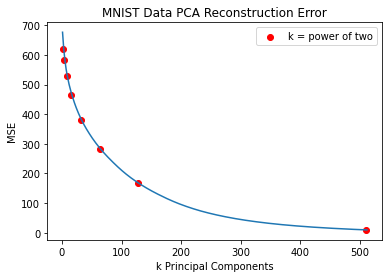

In [26]:
plt.plot(rc_error[:,0], rc_error[:,1])
for i in range(1,8):
    plt.scatter(2**i, rc_error[2**i,1], color='red')

plt.scatter(511, rc_error[511, 1], color='red', label="k = power of two")

plt.xlabel("k Principal Components")
plt.ylabel("MSE")
plt.title("MNIST Data PCA Reconstruction Error")

plt.legend()
plt.show()

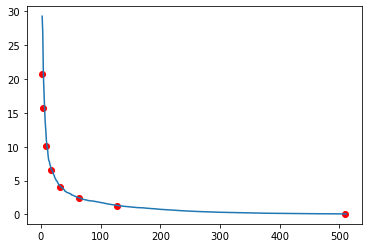

In [102]:
finite_dif = (rc_error[:rc_error.shape[0]-1,1]-rc_error[1:,1])
plt.plot(rc_error[1:,0], finite_dif)

for i in range(1,8):
    plt.scatter(2**i, finite_dif[2**i], color='red')
    
plt.scatter(510, finite_dif[510], color='red')

In [19]:
# function to calculate the angle β

def beta(s, j, X_sample):
    # numerator index
    index_num = (2*j-1)*(2**(s-1))
    # denominator index
    index_den = (j-1)*(2**s)
    
    num = np.sqrt(np.sum(abs(X_sample[index_num : index_num+2**(s-1)])**2))
    den = np.sqrt(np.sum(abs(X_sample[index_den : index_den+2**(s)])**2))
    
    if den == 0:
        #print("Zero denominator!")
        beta = 0
    else:
        beta = 2*np.arcsin(num/den)
    
    print(s, j)
    
    return beta

In [3]:
def decimalToBinary(n, length):
    binary = bin(n).replace("0b", "")
    if len(binary) != length:
        for i in range(length - len(binary)):
            binary = "0" + binary
    
    return binary

def locate_x(current_j, prev_j, length):
    loc = []
    
    prev_binary = decimalToBinary(prev_j, length)
    counter = 0
    
    for i in decimalToBinary(current_j, length):
        if i != prev_binary[counter]:
            loc.append(counter)
        counter += 1
    
    return loc

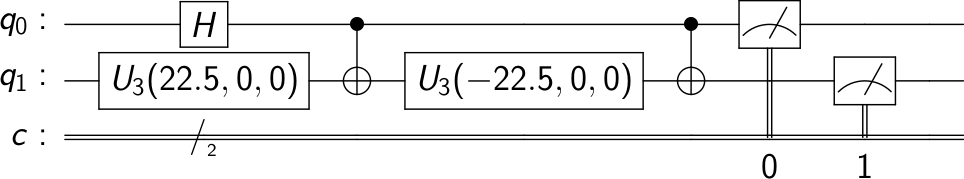

In [39]:
n = 2

qr = QuantumRegister(n, 'q')
cr = ClassicalRegister(n, 'c')
qc = QuantumCircuit(qr, cr)

control = [Qubit(qr, c) for c in range(n-1)]
target = Qubit(qr, n-1)
    
qc.h(0)

# beta(n-i, (2**i)-j, X_sample)
qc.mcry(45, control, target, None)

qc.measure([0,1], [0,1])

qc.draw('latex')

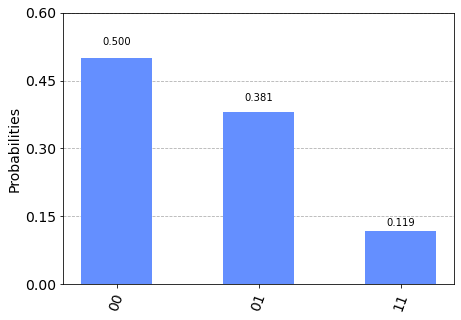

In [40]:
counts = execute(qc, backend=simulator, shots=1000000).result().get_counts(qc)
plot_histogram(counts)

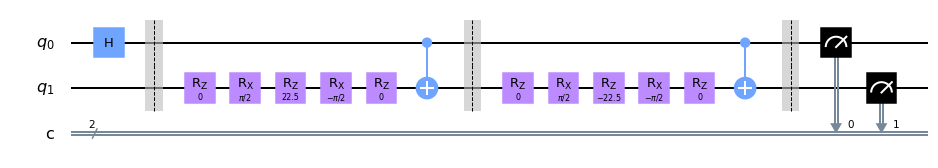

In [41]:
theta = 45

qc = QuantumCircuit(2,2)

qc.h(0)
qc.barrier()

qc.rz(0, 1)
qc.rx(np.pi/2, 1)
qc.rz(theta/2, 1)
qc.rx(-np.pi/2, 1)
qc.rz(0, 1)
qc.cnot(0,1)
qc.barrier()

qc.rz(0, 1)
qc.rx(np.pi/2, 1)
qc.rz(-theta/2, 1)
qc.rx(-np.pi/2, 1)
qc.rz(0, 1)
qc.cnot(0,1)
qc.barrier()

qc.measure([0,1], [0,1])

qc.draw('mpl')

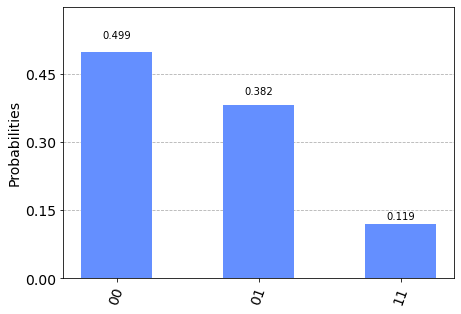

In [42]:
counts = execute(qc, backend=simulator, shots=1000000).result().get_counts(qc)
plot_histogram(counts)

In [4]:
def state_prep_qiskit(X_sample):

    n = int(np.log2(len(X_sample)))

    qr = QuantumRegister(n, 'q')
    cr = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(qr, cr)

    # for every qubits
    for i in range(n):
        # for every gates on the qubit
        if i == 0:
            qc.ry(beta(n, 1, X_sample), 0)
            qc.barrier()
        else:
            for j in range(2**i):
                if j != 0:
                    for loc in locate_x((2**i)-j-1, (2**i)-j, length=i):
                        qc.x(loc)

                control = [Qubit(qr, c) for c in range(i)]
                target = Qubit(qr, i)

                qc.mcry(beta(n-i, (2**i)-j, X_sample), control, target, None)

            for k in range(i):
                qc.x(k)

            qc.barrier()

    #qc.measure([b for b in range(n)], [b for b in range(n)])

    return qc

In [ ]:
def state_prep_pennylane(X_sample):
    
    n = int(np.log2(len(X_sample)))

    # for every qubits
    for i in range(n):
        # for every gates on the qubit
        if i == 0:
            qml.RY(beta(n, 1, X_sample), wires=0)
        else:
            for j in range(2**i):
                if j != 0:
                    for loc in locate_x((2**i)-j-1, (2**i)-j, length=i):
                        qml.PauliX(wires=loc)

                control = [Qubit(qr, c) for c in range(i)]
                target = Qubit(qr, i)

                qc.mcry(beta(n-i, (2**i)-j, X_sample), control, target, None)

            for k in range(i):
                qml.PauliX(wires=k)

    #qc.measure([b for b in range(n)], [b for b in range(n)])

In [14]:
X_sample = np.array([np.sqrt(0.4), 0, np.sqrt(0.5), np.sqrt(0.1)])

In [23]:
X_sample = np.array([1, 0, -5.5, 0])

In [29]:
X_sample = np.random.rand(16)
X_sample.shape

(16,)

In [24]:
X_sample = X_sample/np.sqrt((np.sum(X_sample**2)))

4 1
3 2
3 1
2 4
2 3
2 2
2 1
1 8
1 7
1 6
1 5
1 4
1 3
1 2
1 1


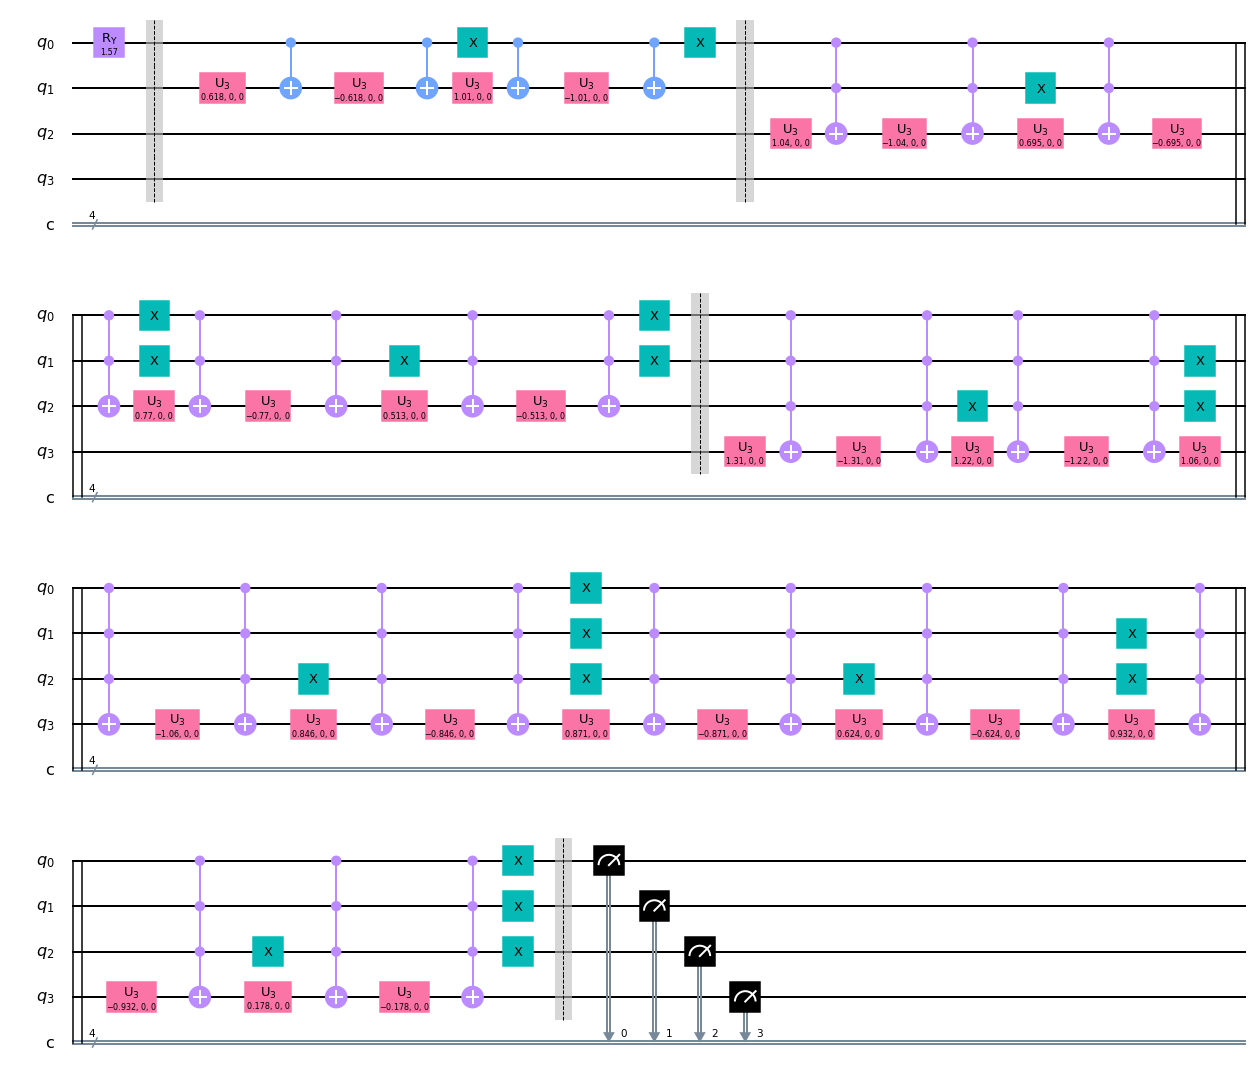

In [30]:
a = state_prep_qiskit(X_sample)
n = int(np.log2(len(X_sample)))
a.measure([b for b in range(n)], [b for b in range(n)])
a.draw('mpl')

In [19]:
beta(1, 1, X_sample)

0.0

In [27]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')

from qiskit.visualization import plot_histogram

[0.032 0.    0.968 0.   ]


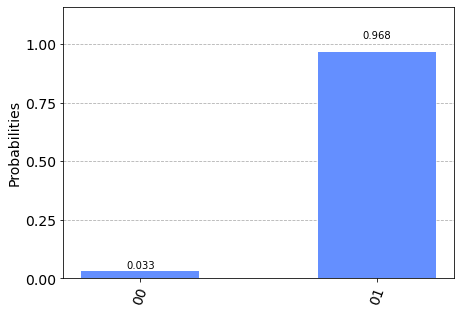

In [28]:
counts = execute(a, backend=simulator, shots=10000).result().get_counts(a)
print(X_sample**2)
plot_histogram(counts)